# Breast Tumor Classification using feature extraction technique based on VGG16

### This below two cell must be executed to access data from drive (if it's stored on it ), if you want run it on Google Colab

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
cd drive/

/content/drive


# Classification of Benign/Malignant using feature extraction of pre-trained model (VGG16)

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(320, 320, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
import os

In [0]:
base_dir = '/content/drive/CV_dataset/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 10, 10, 512)       14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 27,822,401
Trainable params: 27,822,401
Non-trainable params: 0
_________________________________________________________________


## Freezing the convlution base of VGG16

In [0]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


## Augmenting the training data

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(320, 320), batch_size=8, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_dir, target_size=(320, 320), batch_size=8, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=25,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

Found 179 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
Epoch 1/50
 - 145s - loss: 0.7762 - acc: 0.4965 - val_loss: 0.7774 - val_acc: 0.4000
Epoch 2/50
 - 9s - loss: 0.7012 - acc: 0.5485 - val_loss: 0.6453 - val_acc: 0.6250
Epoch 3/50
 - 9s - loss: 0.6629 - acc: 0.6283 - val_loss: 0.6278 - val_acc: 0.6125
Epoch 4/50
 - 9s - loss: 0.6613 - acc: 0.6136 - val_loss: 0.6275 - val_acc: 0.6375
Epoch 5/50
 - 11s - loss: 0.6137 - acc: 0.6250 - val_loss: 0.6315 - val_acc: 0.6250
Epoch 6/50
 - 10s - loss: 0.6612 - acc: 0.6253 - val_loss: 0.6260 - val_acc: 0.6250
Epoch 7/50
 - 10s - loss: 0.5846 - acc: 0.6667 - val_loss: 0.6282 - val_acc: 0.6625
Epoch 8/50
 - 10s - loss: 0.5968 - acc: 0.6667 - val_loss: 0.6206 - val_acc: 0.6375
Epoch 9/50
 - 10s - loss: 0.5922 - acc: 0.6897 - val_loss: 0.6460 - val_acc: 0.6125
Epoch 10/50
 - 10s - loss: 0.6040 - acc: 0.6456 - val_loss: 0.6796 - val_acc: 0.6375
Epoch 11/50
 - 11s - loss: 0.6307 - acc: 0.6146 - val_loss: 0.6268 - val_acc: 0

## Plotting the training & Validation accuracy and loss value

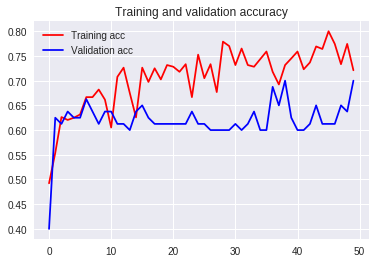

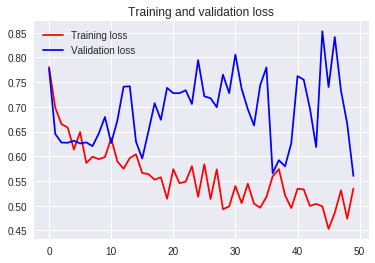

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Saving the trained model

In [0]:
model.save('cancer_classification_model_using_feature_extraction_VGG16.h5')